In [1]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch
from chirho.dynamical.handlers import LogTrajectory
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from pyro.infer import Predictive

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver

smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
num_iterations = 50 if smoke_test else 100
num_samples = 20 if smoke_test else 100
num_steps = 100 if smoke_test else 400
sample_size = 100 if smoke_test else 300
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()


notebook_starts = time.time()

In [2]:
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)

with open(locust_count_data_path, "rb") as f:
    locust_count_data = dill.load(f)

count_data = locust_count_data["count_data"]


def get_count_data_subset(count_data, start, end):
    count_subset = {key: count_data[key][start:end] for key in count_data.keys()}
    init_state = {key[:-4]: count_subset[key][0] for key in count_subset.keys()}

    return {"count_subset": count_subset, "init_state": init_state}


In [3]:

piecemeal_path = os.path.join(root, "data/foraging/locust/ds/time_slices/")

samples_file_path = os.path.join(piecemeal_path, "samples.pkl")
if os.path.exists(samples_file_path):
    with open(samples_file_path, 'rb') as file:
        samples = dill.load(file)
else:
    print("No samples file found, creating new dict")
    samples = {}

start = 80
ends = [start + end for end in [10, 20, 30, 40, 50, 60, 70, 80]]
step_size = 1

for end in ends:
    if f"s{start}_e{end}_steps{num_steps}" not in samples.keys():

        start_time = torch.tensor(1).float()
        end_time = torch.tensor(250 + 1).float()

        c_data = get_count_data_subset(count_data, start, end)

        logging_times = torch.arange(start, end, step_size)

        print("running inference for ", f"s{start}_e{end}_steps{num_steps}")
        guide = ft.run_svi_inference(
                model=lc.conditioned_locust_model,
                num_steps=num_steps,
                verbose=True,
                lr=0.03,
                blocked_sites=["counts_obs"],
                obs_times=logging_times,
                data=c_data['count_subset'],
                init_state=c_data['init_state'],
                start_time=start_time,
            )


        predictive = Predictive(
            lc.simulated_bayesian_locust, guide=guide,
            num_samples=num_samples
        )

        samples[f"s{start}_e{end}_steps{num_steps}"] = predictive(c_data['init_state'], 
                                                            start_time, logging_times)

        with open(samples_file_path, 'wb') as file:
            dill.dump(samples, file)


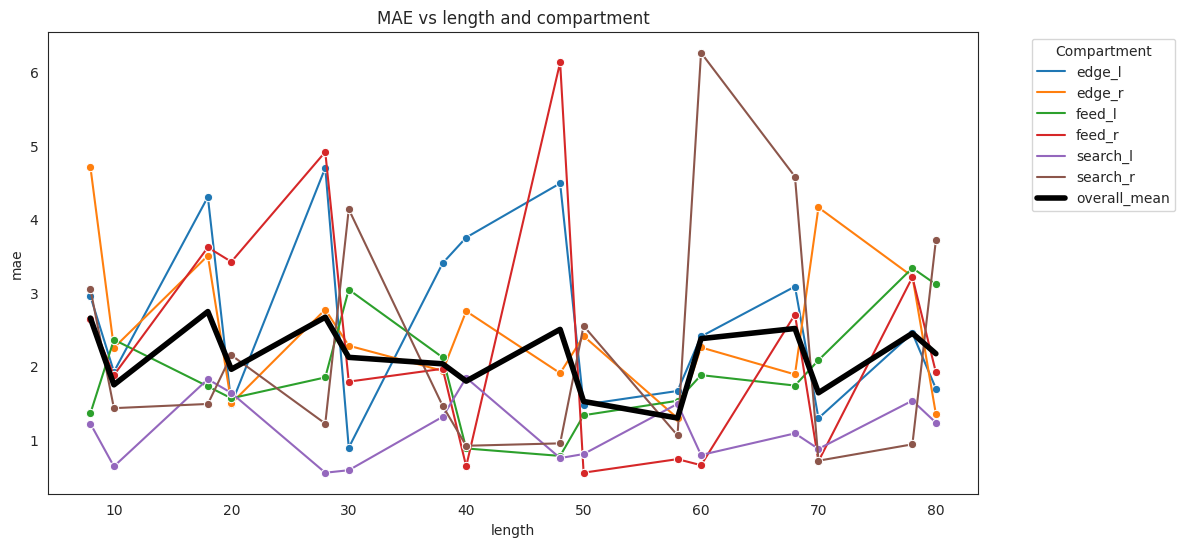

In [4]:
import re
import pandas as pd

samples_400 =  {key: value for key, value in samples.items() if key.endswith('400')}
samples_400.keys()

pattern = re.compile(r's(\d+)_e(\d+)_steps(\d+)')



df = pd.DataFrame(columns=['start', 'end', 'length','edge_l', 'edge_r', 'feed_l', 'feed_r', 'search_l', 'search_r', 'overall_mean'])


for key, value in samples_400.items():
    match = pattern.match(key)
    start = int(match.group(1))
    end = int(match.group(2))
    if start == 0:
        start += 1
        end -= 1
    count_subset = get_count_data_subset(count_data, start, end)['count_subset']


    mean_preds = {}
    abs_errors = {}
    maes = {}
    for compartment in ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]:
        mean_preds[compartment] = value[compartment].mean(dim=0)
        abs_errors[compartment] = torch.abs(count_subset[f"{compartment}_obs"] - mean_preds[compartment])
        maes[compartment] = abs_errors[compartment].mean()
    all_errors = torch.cat([tensor for tensor in abs_errors.values()])
    overall_mean = torch.mean(all_errors).item()
    df.loc[key] = [start, end, end - start] +[maes[var].item() for var in df.columns[3:-1]] +  [overall_mean]


df_for_plot = df.melt(id_vars=['length'], value_vars=df.columns[3:-1], var_name='compartment', value_name='MAE')

plt.figure(figsize=(12, 6))
sns.lineplot(x='length', y='MAE', hue='compartment', data=df_for_plot, marker='o')

sns.lineplot(x=df['length'], y=df['overall_mean'], label='overall_mean', 
             linewidth=4.0, color='black')  

plt.xlabel('length')
plt.ylabel('mae')
plt.title('MAE vs length and compartment')
plt.legend(title='Compartment', bbox_to_anchor=(1.05, 1), loc='upper left')



plt.show()

{'edge_l': tensor(3.4280, dtype=torch.float64), 'edge_r': tensor(1.9380, dtype=torch.float64), 'feed_l': tensor(2.1455, dtype=torch.float64), 'feed_r': tensor(1.9656, dtype=torch.float64), 'search_l': tensor(1.2239, dtype=torch.float64), 'search_r': tensor(1.5915, dtype=torch.float64)}


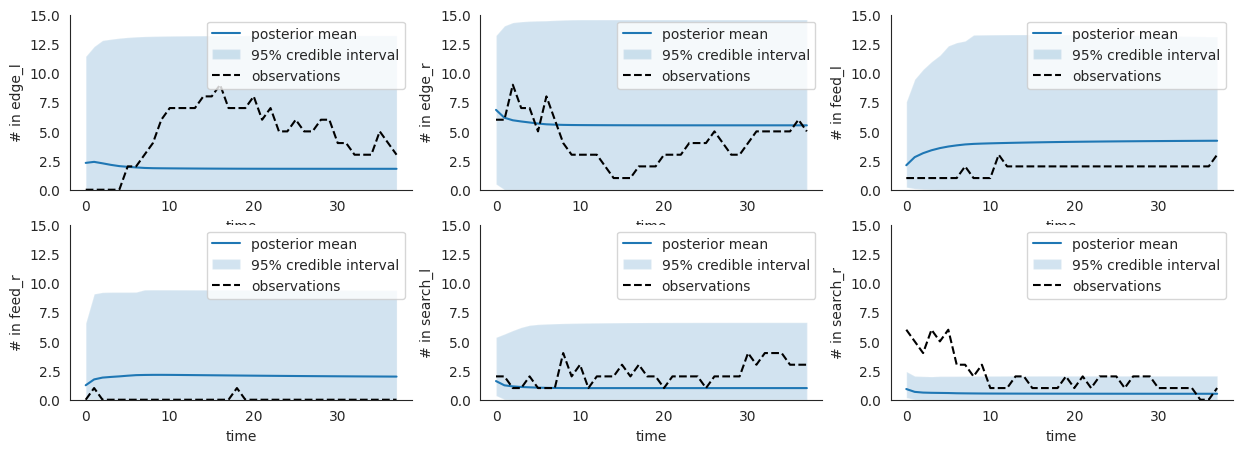

In [11]:
start, end, num_steps = 0, 40, 400
batch = f"s{start}_e{end}_steps{num_steps}"
subsamples = samples[batch]
count_subset = get_count_data_subset(count_data, start, end)['count_subset']


mean_preds = {}
abs_errors = {}
maes = {}
for key in ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]:
    mean_preds[key] = subsamples[key].mean(dim=0)
    abs_errors[key] = torch.abs(count_subset[f"{key}_obs"][:-2] - mean_preds[key])
    maes[key] = abs_errors[key].mean()

print(maes)


fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    ft.ds_uncertainty_plot(
        state_pred=subsamples[state],
        data=count_subset[f"{state}_obs"][:-2], #TODO this is hacky
        ylabel=f"# in {state}",
        color=color,
        data_label="observations",
        ax=ax[i],
        legend=True,
        test_plot=False,
        mean_label="posterior mean",
        ylim = 15
    )

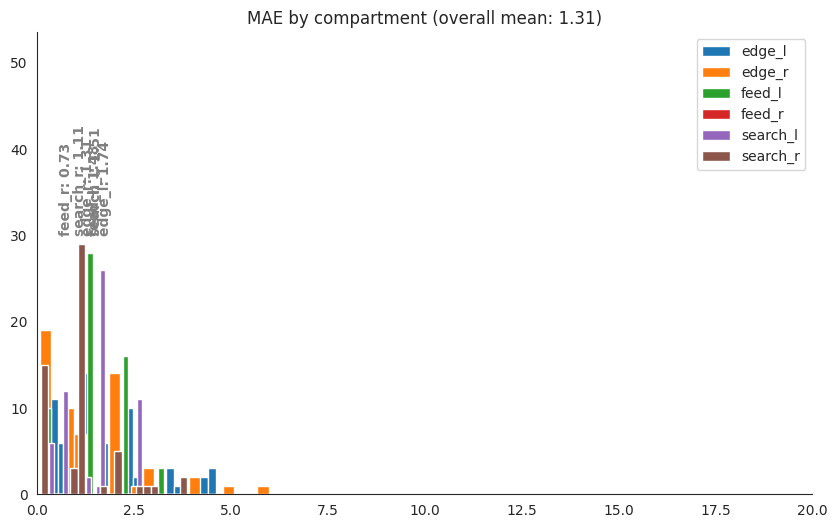

In [9]:
all_errors = torch.cat([tensor for tensor in abs_errors.values()])
overall_mean = torch.mean(all_errors).item()

plt.figure(figsize=(10, 6))
for key, tensor in abs_errors.items():
    plt.hist(tensor, label=key, bins=20)

for key, tensor in abs_errors.items():
    mean = torch.mean(tensor).item()
    plt.text(mean, 30, f'{key}: {mean:.2f}', rotation=90, va='bottom', ha='center', color='gray', weight='bold')

plt.title(f"MAE by compartment (overall mean: {overall_mean:.2f})")

plt.xlim(0, 20)
sns.despine()
plt.legend()
plt.show()

